In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import gc
import itertools

import torch.utils.data as data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from tqdm import tqdm_notebook
from PIL import Image
from dataset import KneeGradingDataset
from model import KneeNet
from augmentation import CenterCrop
from val_utils import validate_epoch
from copy import deepcopy
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score, roc_auc_score, roc_curve, log_loss
from sklearn.preprocessing import OneHotEncoder
from dataset import get_pair
from augmentation import CenterCrop
import cv2

In [3]:
def load_picture16bit(fname):
    patch_transform = transforms.Compose([
            transforms.ToTensor(),
            lambda x: x.float(),
            normTransform,
        ])
    
    
    img = Image.open(fname)

    tmp = np.array(img, dtype=float)
    img = Image.fromarray(np.uint8(255*(tmp/65535.)))
    img_orig = img.copy()
    
    cropper = CenterCrop(300)

    
    l, m = get_pair(cropper(img))

    l = patch_transform(l)
    m = patch_transform(m)
    
    return cropper(img), l.view(1, 1, 128, 128), m.view(1, 1, 128, 128)


def smoth_edge_mask(s, w):
    res = np.zeros((s+w*2, s+w*2))
    res[w:w+s, w:w+s] = 1
    res = cv2.blur(res,(2*w,2*w))
    
    return res[w:w+s, w:w+s]

def inverse_pair_mapping(l, m, s, ps=128, smoothing=7):
    pad = int(np.floor(s/3))
    
    l = cv2.resize(l, (ps, ps), cv2.INTER_CUBIC)
    l *= smoth_edge_mask(l.shape[0], smoothing)
    
    m = cv2.resize(m, (ps, ps), cv2.INTER_CUBIC)
    m *= smoth_edge_mask(m.shape[0], smoothing)
    
    hm = np.zeros((s, s))
    hm[pad:pad+ps, 0:ps] = l
    hm[pad:pad+ps, s-ps:] = m
    
    return hm

In [4]:
class KneeNetEnsemble(nn.Module):
    def __init__(self, nets):
        super().__init__()
        net1 = nets[0]
        net1.final = nets[0].final[1]
        
        net2 = nets[1]
        net2.final = nets[1].final[1]
        
        net3 = nets[2]
        net3.final = nets[2].final[1]
        
        self.net1 = deepcopy(net1)
        self.net2 = deepcopy(net2)
        self.net3 = deepcopy(net3)
        
        self.grads_l1 = []
        self.grads_m1 = []
        
        self.grads_l2 = []
        self.grads_m2 = []
        
        self.grads_l3 = []
        self.grads_m3 = []
        
    def decopmpose_forward_avg(self, net, l, m):
        l_o = net.branch(l)
        m_o = net.branch(m)
        
        concat = torch.cat([l_o, m_o],1)
        o = net.final(concat.view(l.size(0), 512))
        return l_o, m_o, o
    
    def extract_features_branch(self, net, l, m, wl, wm):
        def weigh_maps(weights, maps):
            maps = maps.squeeze()
            weights = weights.squeeze()

            res = torch.zeros(maps.size()[-2:]).cuda()

            for i, w in enumerate(weights):
                res+=w*maps[i]

            return res
        # We need to re-assemble the architecture
        branch = nn.Sequential(net.branch.block1,
                               nn.MaxPool2d(2),
                               net.branch.block2,
                               nn.MaxPool2d(2),
                               net.branch.block3)
        
        o_l = branch(l).data
        o_m = branch(m).data             
        # After extracting the features, we weigh them based on the provided weights
        o_l = weigh_maps(wl, o_l)
        o_m = weigh_maps(wm, o_m)
        return F.relu(o_l), F.relu(o_m)
    
    def compute_gradcam(self, l, m, img_size, ps, smoothing=7):
        wl, wm = self.grads_l1[0].data, self.grads_m1[0].data
        ol1, om1 = self.extract_features_branch(self.net1, l, m, wl, wm)
        
        wl, wm = self.grads_l2[0].data, self.grads_m2[0].data
        ol2, om2 = self.extract_features_branch(self.net1, l, m, wl, wm)
        
        wl, wm = self.grads_l3[0].data, self.grads_m3[0].data
        ol3, om3 = self.extract_features_branch(self.net1, l, m, wl, wm)

        l_out = (ol1 + ol2 + ol3) / 3.

        
        m_out = (om1 + om2 + om3) / 3.

        heatmap = inverse_pair_mapping(l_out.data.cpu().numpy(), 
                                       np.fliplr(m_out.data.cpu().numpy()),
                                       img_size, ps, smoothing)
        
        
        heatmap -= heatmap.min()
        heatmap /= heatmap.max()
        
        return heatmap
        
    def forward(self, l, m):
        self.grads_l1 = []
        self.grads_m1 = []
        
        self.grads_l2 = []
        self.grads_m2 = []
        
        self.grads_l3 = []
        self.grads_m3 = []
        
        # Producing the branch outputs and registering the corresponding hooks for attention maps
        # Net 1
        l_o1, m_o1, o1 = self.decopmpose_forward_avg(self.net1, l, m)
        l_o1.register_hook(lambda grad: self.grads_l1.append(grad))
        m_o1.register_hook(lambda grad: self.grads_m1.append(grad))
        # Net 2
        l_o2, m_o2, o2 = self.decopmpose_forward_avg(self.net2, l, m)
        l_o2.register_hook(lambda grad: self.grads_l2.append(grad))
        m_o2.register_hook(lambda grad: self.grads_m2.append(grad))
        # Net 3
        l_o3, m_o3, o3 = self.decopmpose_forward_avg(self.net3, l, m)
        l_o3.register_hook(lambda grad: self.grads_l3.append(grad))
        m_o3.register_hook(lambda grad: self.grads_m3.append(grad))

        
        return o1+o2+o3

In [5]:
FOLDS_LOCATION = '../snapshots_knee_grading/'
snaps = ['2017_10_10_12_30_42', '2017_10_10_12_30_46', '2017_10_10_12_30_49']



mean_vector, std_vector = np.load(os.path.join('../snapshots_knee_grading/mean_std.npy'))
normTransform = transforms.Normalize(mean_vector, std_vector)
patch_transform = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x.float(),
        normTransform,
    ])

test_files = os.listdir('../../KL_data/test/')
val_ds = KneeGradingDataset('../../KL_data/', 
                            test_files, 
                            transform=patch_transform,
                            augment=CenterCrop(300),
                            stage='test')

val_loader = data.DataLoader(val_ds, batch_size=64, num_workers=10)

avg_preds = {}
labels = {}

nets = []
for fold in snaps:

    
    for snp_name in os.listdir(os.path.join(FOLDS_LOCATION, fold)):
        if snp_name.endswith('pth'):
            break
            
    print(snp_name, int(snp_name.split('_')[1][:-4])*500)
    snap_path = os.path.join(FOLDS_LOCATION, fold, snp_name)
    net = nn.DataParallel(KneeNet(64, 0.2, True))
    net.load_state_dict(torch.load(snap_path))
    nets.append(deepcopy(net.module))

epoch_64.pth 32000
epoch_97.pth 48500
epoch_96.pth 48000


In [6]:
net = nn.DataParallel(KneeNetEnsemble(nets))
net.cuda();
val_loss, probs, truth, names = validate_epoch(net, val_loader, F.cross_entropy)

Processing: 100%|█████████████████████████████████████████| 94/94 [00:48<00:00,  7.98it/s]


In [7]:
preds = probs.argmax(1)
# Validation metrics
cm = confusion_matrix(truth, preds)
kappa = np.round(cohen_kappa_score(truth, preds, weights="quadratic"),10)
acc = np.round(100*np.mean(cm.diagonal().astype(float)/cm.sum(axis=1)),4)
mse = np.round(mean_squared_error(truth, preds), 4)

fpr1, tpr1, _ = roc_curve(truth>1, probs[:,2:].sum(1))
auc = np.round(roc_auc_score(truth>1, probs[:,2:].sum(1)),4)


loss=np.round(log_loss(truth, probs),4)

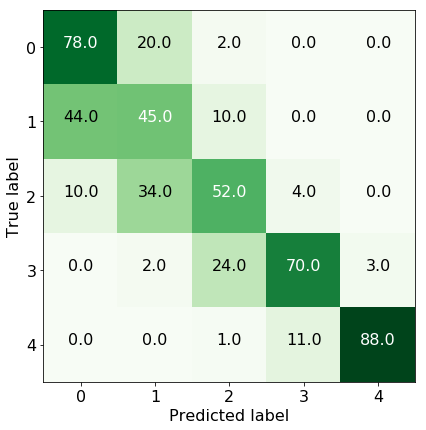

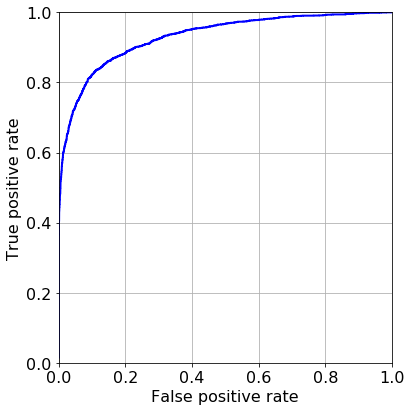

Kappa: 0.8270777646
Avg. class accuracy 66.7137
MSE 0.482
AUC 0.9308
Cross-entropy: 1.0898


In [8]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(6,6))
cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens, resample=False)
classes = ['No OA', 'Doubtful OA', 'Early OA','Mild OA','End-stage']
#plt.colorbar()
tick_marks = np.arange(len(classes))

#plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j]*100,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('conf_Our.png', bbox_inches='tight', dpi=350)
Image.open('conf_Our.png').convert('RGB').save('conf_Our.jpg', format='JPEG', subsampling=0, quality=100)
plt.show()

matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(6,6))
plt.plot(fpr1, tpr1, label='Own'.format(preds.shape[0]),lw=2, c='b')
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('ROC_AUC_test.png', bbox_inches='tight', dpi=300)
Image.open('ROC_AUC_test.png').convert('RGB').save('ROC_AUC_test.jpg', format='JPEG', subsampling=0, quality=100)
plt.show()

print('Kappa:', kappa)
print('Avg. class accuracy', acc)
print('MSE', mse)
print('AUC',auc)
print('Cross-entropy:', loss)

In [11]:
# Producing the GradCAM output using the equations provided in the article
if not os.path.isdir('../probs_own'):
    os.mkdir('../heatmaps_own/')
    os.mkdir('../probs_own/')
    
    
to_check = set(np.loadtxt('../maps_check.txt', dtype=str).tolist())
pbar = tqdm_notebook(total=len(to_check))
for fname in test_files:
    if not ('_'.join(fname.split('_')[:3]) in to_check):
        continue
    img, l, m = load_picture16bit('../../KL_data/test/'+fname)
    net.train(True)
    net.zero_grad()
    out = net.module(Variable(l.cuda()), Variable(m.cuda()))
    ohe = OneHotEncoder(sparse=False, n_values=5)
    index = np.argmax(out.cpu().data.numpy(), axis=1).reshape(-1, 1)
    out.backward(torch.from_numpy(ohe.fit_transform(index)).float().cuda())

    heatmap = net.module.compute_gradcam(Variable(l.cuda()), Variable(m.cuda()), 300, 128, 7)

    plt.figure(figsize=(7,7))
    plt.imshow(np.array(img), cmap=plt.cm.Greys_r)
    plt.imshow(heatmap, cmap=plt.cm.jet, alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('../heatmaps_own/'+fname, bbox_inches='tight', dpi=300, pad_inches = 0)
    plt.close()


    plt.figure(figsize=(7,1))
    probs = F.softmax(out).cpu().data[0].numpy()
    for kl in range(5):
        plt.text(kl-0.2, 0.35, "%.2f" % np.round(probs[kl],2), fontsize=15)
    plt.bar(np.array([0, 1, 2, 3, 4]),probs, color='red',align='center',tick_label=['KL0','KL1','KL2','KL3','KL4'],alpha=0.3)
    plt.ylim(0,1)
    plt.yticks([])
    plt.savefig('../probs_own/'+fname, bbox_inches='tight', dpi=300, pad_inches = 0)
    plt.close()
    pbar.update(1)
    
pbar.close()